In [11]:
import os
import json
import numpy as np
from quinine import QuinineArgumentParser
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import copy
import matplotlib.pyplot as plt
import torch.nn.functional as F

import sys
sys.path.append('../scripts')
from nano_gpt import GPT2Model, GPT2Config

from utils import aggregate_metrics, eval_unlooped_model, eval_looped_model, get_model

In [12]:
fig_hparam = {
    'figsize': (8, 5),
    'labelsize': 28,
    'ticksize': 20,
    'linewidth': 5,
    'fontsize': 15,
    'titlesize': 20,
    'markersize': 15
}

# font specification
fontdict = {'family': 'serif',
         'size': fig_hparam['fontsize'],
         }

In [13]:
device = torch.device('cuda:0')

## Get dataset

In [14]:
class SparseLinearRegression():
    def __init__(self, batch_size, n_points, n_dims, n_dims_truncated, device, w_star=None, sparsity=3):
        super(SparseLinearRegression, self).__init__()
        self.device = device
        self.xs = torch.randn(batch_size, n_points, n_dims).to(device)
        self.xs[..., n_dims_truncated:] = 0
        w_b = torch.randn(batch_size, n_dims, 1) if w_star is None else w_star.to(device)  # [B, d, 1]
        w_b[:, n_dims_truncated:] = 0
        self.w_b = w_b.to(device)
        
        self.sparsity = sparsity
        valid_coords = n_dims
        for i, w in enumerate(self.w_b):  # [B, d, 1]
            mask = torch.ones(n_dims).bool()  # [d]
            perm = torch.randperm(valid_coords)
            mask[perm[:sparsity]] = False
            w[mask] = 0  # w shape [d, 1]

        self.ys = (self.xs @ self.w_b).sum(-1)  # [B, n]
        
        
        
sample_size = 1280
batch_size = 128
n_points = 41
n_dims_truncated = 20
n_dims = 20

real_task = SparseLinearRegression(sample_size, n_points, n_dims, n_dims_truncated, device)
xs, ys, w_b = real_task.xs, real_task.ys, real_task.w_b

## load model

In [44]:
result_dir = '../results2/sparse_LR_baseline'
run_id = '0623214332-SparseLR_baseline-60a2'

from models import TransformerModel

n_positions = 101
n_embd = 256
n_layer = 12
n_head = 8

model = TransformerModel(n_dims, n_positions, n_embd, n_layer, n_head)
step = -1
model = get_model(model, result_dir, run_id, step)
model = model.to(device)

err, y_pred_total = eval_unlooped_model(model, xs, ys)


number of parameters: 9.48M


In [45]:
result_errs = {}
result_errs['Transformer'] = err

## Load looped transformer

In [46]:
from models import TransformerModelLooped

result_dir = '../results2/sparse_LR_loop'
run_id = '0706234720-SparseLR_loop_L1_ends{20}_T{10}_all-8969'

n_positions = 101
n_embd = 256
n_head = 8
T = 500
n_layer = 1

model = TransformerModelLooped(n_dims, n_positions, n_embd, n_layer, n_head)
step = -1
model = get_model(model, result_dir, run_id, step)
model = model.to(device)

err, loop_err = eval_looped_model(model, xs, ys, loop_max=T)

result_errs['Looped Transformer'] = err

number of parameters: 0.79M
0


### Also get the "weak" baseline

In [47]:
from utils import get_relevant_baselines
from utils import LeastSquaresModel, NNModel, AveragingModel, LassoModel

baselines = get_relevant_baselines("sparse_linear_regression")
baselines = [
    (LeastSquaresModel, {}),
    (NNModel, {"n_neighbors": 3}),
    (AveragingModel, {}),
] + [
#     (LassoModel, {"alpha": alpha}) for alpha in [1, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001]
    (LassoModel, {"alpha": alpha}) for alpha in [0.01]
]
baseline_models = [model_cls(**kwargs) for model_cls, kwargs in baselines]
baseline_errs = {}
for baseline_model in baseline_models:
    y_pred = baseline_model(xs, ys)
    err = (y_pred.cpu() - ys.cpu()).square()
    result_errs[baseline_model.name] = err

In [48]:
result_errs_agg = aggregate_metrics(result_errs, 3)

In [49]:
result_errs_agg

{'Transformer': {'mean': tensor([1.0737, 0.8867, 0.7994, 0.8419, 0.6357, 0.5842, 0.4095, 0.3024, 0.2210,
          0.1307, 0.0848, 0.0714, 0.0390, 0.0295, 0.0170, 0.0153, 0.0099, 0.0091,
          0.0064, 0.0062, 0.0048, 0.0045, 0.0037, 0.0032, 0.0026, 0.0026, 0.0028,
          0.0023, 0.0023, 0.0021, 0.0021, 0.0019, 0.0018, 0.0021, 0.0017, 0.0016,
          0.0017, 0.0016, 0.0015, 0.0015, 0.0017]),
  'std': tensor([2.3011, 1.7805, 1.6767, 1.9931, 1.3350, 2.0973, 1.2930, 0.9452, 0.6205,
          0.4855, 0.3265, 0.4831, 0.1498, 0.1175, 0.0617, 0.0711, 0.0307, 0.0275,
          0.0173, 0.0173, 0.0164, 0.0111, 0.0084, 0.0093, 0.0060, 0.0057, 0.0075,
          0.0050, 0.0055, 0.0064, 0.0058, 0.0036, 0.0049, 0.0145, 0.0051, 0.0048,
          0.0039, 0.0051, 0.0033, 0.0028, 0.0046]),
  'bootstrap_low': tensor([0.9659, 0.8115, 0.7261, 0.7587, 0.5766, 0.4999, 0.3545, 0.2625, 0.1929,
          0.1082, 0.0716, 0.0525, 0.0323, 0.0245, 0.0145, 0.0124, 0.0087, 0.0080,
          0.0056, 0.0055, 0.0

In [33]:
result_errs_agg.keys()

dict_keys(['Transformer', 'Looped Transformer', 'Least Squares', '3-Nearest Neighbors', 'Averaging', 'Lasso (alpha=0.01)'])

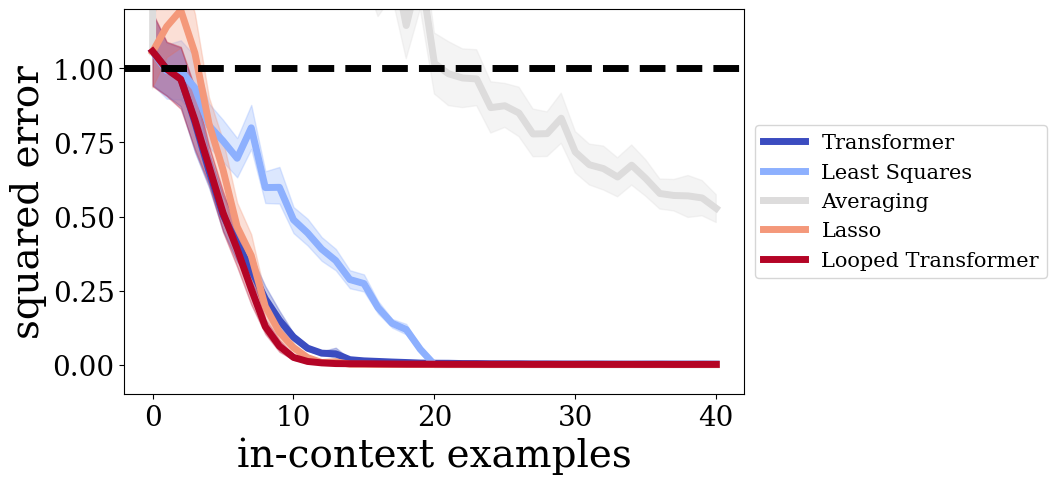

In [36]:
import matplotlib.pyplot as plt
import matplotlib

fig, ax = plt.subplots(1, figsize=fig_hparam['figsize'])

err_result_dict_agg = result_errs_agg

cmap = matplotlib.cm.get_cmap("coolwarm")
result_name_list = ['Transformer', 'Least Squares', 'Averaging', 'Lasso (alpha=0.01)', 'Looped Transformer']  # 
colors = cmap(np.linspace(0, 1, len(result_name_list)))
for idx, model_name in enumerate(result_name_list):
    err = err_result_dict_agg[model_name]["mean"]
    if "Lasso" in model_name:
        label_name = "Lasso"
    else:
        label_name = model_name
    ax.plot(err, color=colors[idx], lw=fig_hparam['linewidth'], label=label_name)
    low = err_result_dict_agg[model_name]["bootstrap_low"]
    high = err_result_dict_agg[model_name]["bootstrap_high"]
    ax.fill_between(range(len(low)), low, high, alpha=0.3, color=colors[idx])

ax.tick_params(axis='both', labelsize=fig_hparam['ticksize'])
ax.axhline(1, color='k', ls='--', lw=fig_hparam['linewidth'])
ax.set_ylim(-0.1, 1.2)
# plt.xticks(np.arange(0, n_points))
plt.rc('font', family='serif')
ax.set_xlabel("in-context examples", fontsize=fig_hparam['labelsize'])
y_label = ax.set_ylabel("squared error", fontsize=fig_hparam['labelsize'])
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fig_hparam['fontsize'])


plt.savefig("result_folder/Figures/SparseLR_err.pdf", format='pdf', dpi=600, bbox_inches='tight')